In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from tabular_policy_maze.maze_env import MazeEnv, plot_maze

---
## Simple 4x4:

<Axes: >

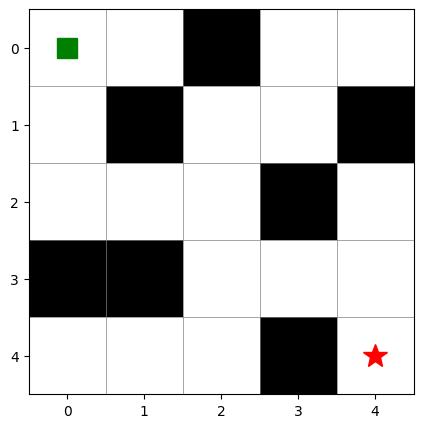

In [135]:
maze = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0],
])

env = MazeEnv(maze, start=(0, 0), goal=(4, 4))
plot_maze(env)

---
## Tabular REINFORCE: (no neural net)

In [136]:
from tabular_policy_maze.reinforce import train_reinforce, sample_trajectory, plot_maze_with_trajectory, plot_steps_distribution, sample_action

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

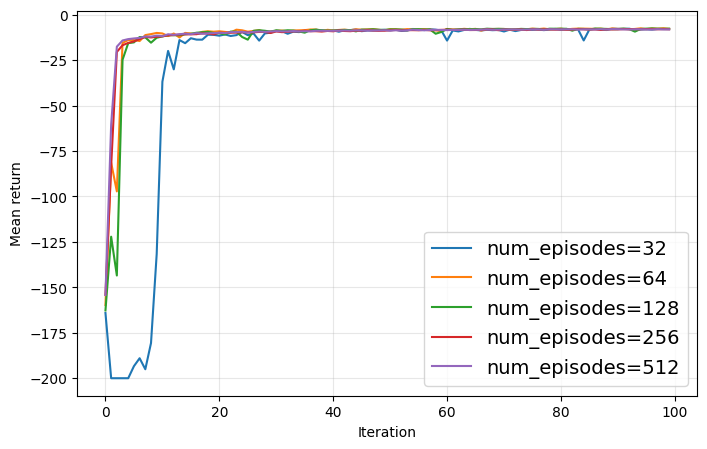

In [ ]:
episodes_list = [32, 64, 128, 256, 512]
n_iter = 100

plt.figure(figsize=(8, 5))

for n_eps in episodes_list:
    theta, mean_returns = train_reinforce(
        env,
        n_iter=n_iter,
        n_episodes=n_eps,
        alpha=0.05,
        gamma=1.0,
    )
    plt.plot(mean_returns, label=f"num_episodes={n_eps}")

plt.xlabel("Iteration")
plt.ylabel("Mean return")
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.show()

<Axes: title={'center': 'Policy rollout  (steps: 10, reached goal)'}>

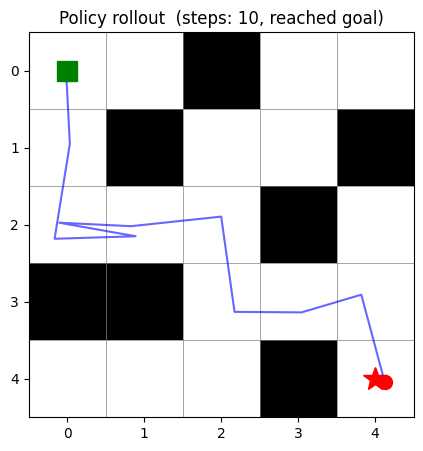

In [149]:
plot_maze_with_trajectory(env, theta, title="Policy rollout")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

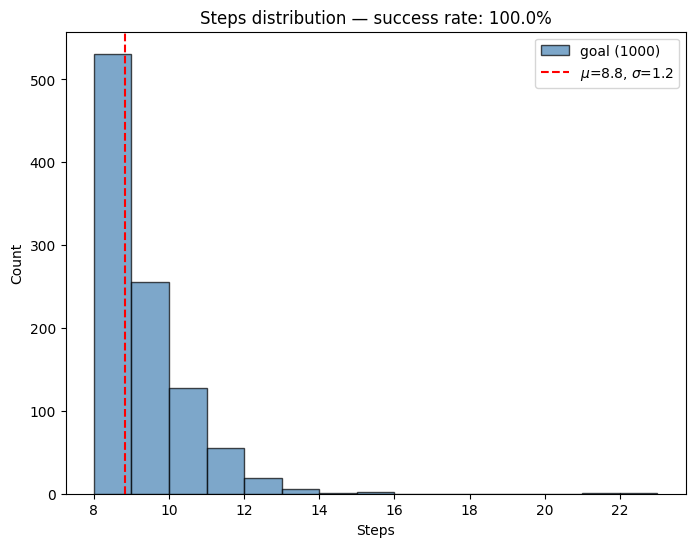

In [150]:
plot_steps_distribution(env, theta, n_trajectories=1000, figsize=(8, 6))

---
## Exploring Tabular Policy for bigger Mazes:

- Let's create function to create maze of given size with given % of obstacles:

In [151]:
from collections import deque

def _bfs_reachable(maze, start, goal):
    H, W = maze.shape
    visited = set()
    queue = deque([start])
    visited.add(start)
    while queue:
        r, c = queue.popleft()
        if (r, c) == goal:
            return True
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < H and 0 <= nc < W and maze[nr, nc] == 0 and (nr, nc) not in visited:
                visited.add((nr, nc))
                queue.append((nr, nc))
    return False

def generate_maze_env(
    size,
    obstacle_pct=0.25,
    max_steps=200,
    step_reward=-1.0,
    goal_reward=0.0,
    seed=None
):
    """
    Generate a random maze and return a MazeEnv with valid start/goal.
    Start = top-left free cell, goal = bottom-right free cell.
    Guarantees a path exists between them (via BFS check + retry).
    """
    rng = np.random.RandomState(seed)
    H, W = (size, size) if isinstance(size, int) else size

    for _ in range(1000):
        maze = (rng.rand(H, W) < obstacle_pct).astype(int)
        # force start and goal free
        maze[0, 0] = 0
        maze[H - 1, W - 1] = 0

        if _bfs_reachable(maze, (0, 0), (H - 1, W - 1)):
            return MazeEnv(maze, start=(0, 0), goal=(H - 1, W - 1),
                           max_steps=max_steps, step_reward=step_reward,
                           goal_reward=goal_reward)

    raise RuntimeError("Could not generate a solvable maze after 1000 attempts")

States: 113, Actions: 4


<Axes: >

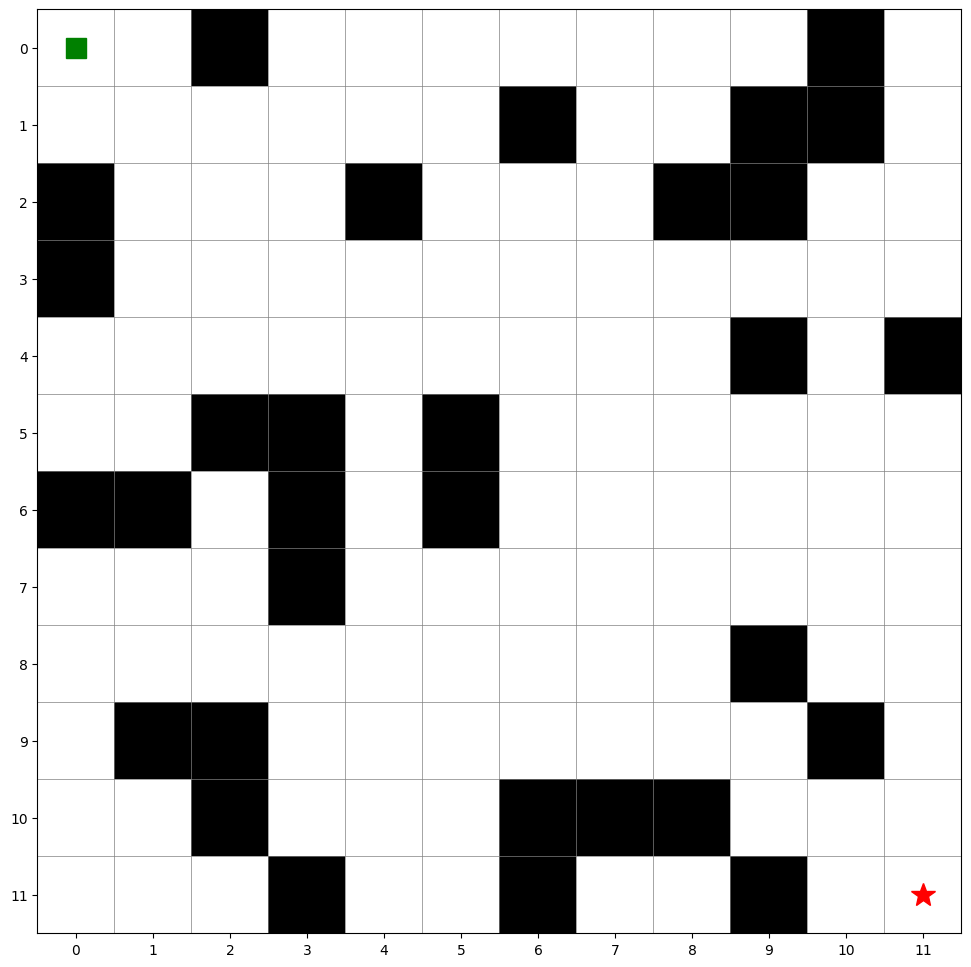

In [156]:
env = generate_maze_env(size=12, obstacle_pct=0.25, seed=50, max_steps=200)
print(f"States: {env.n_states}, Actions: {env.n_actions}")
plot_maze(env)

REINFORCE Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Mean return')

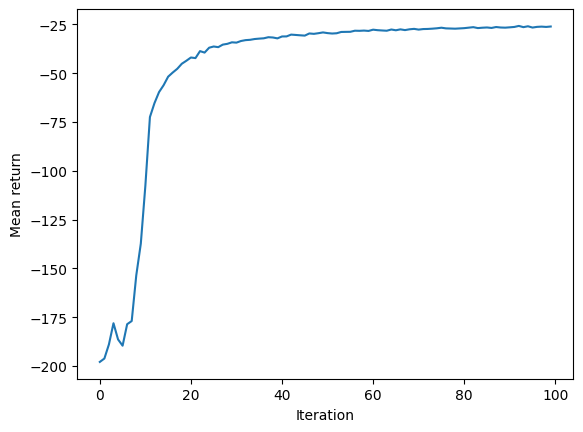

In [157]:
theta, mean_returns = train_reinforce(env, n_iter=100, n_episodes=512, alpha=0.05, gamma=1.0)

plt.plot(mean_returns)
plt.xlabel("Iteration")
plt.ylabel("Mean return")

<Axes: title={'center': 'Policy rollout  (steps: 24, reached goal)'}>

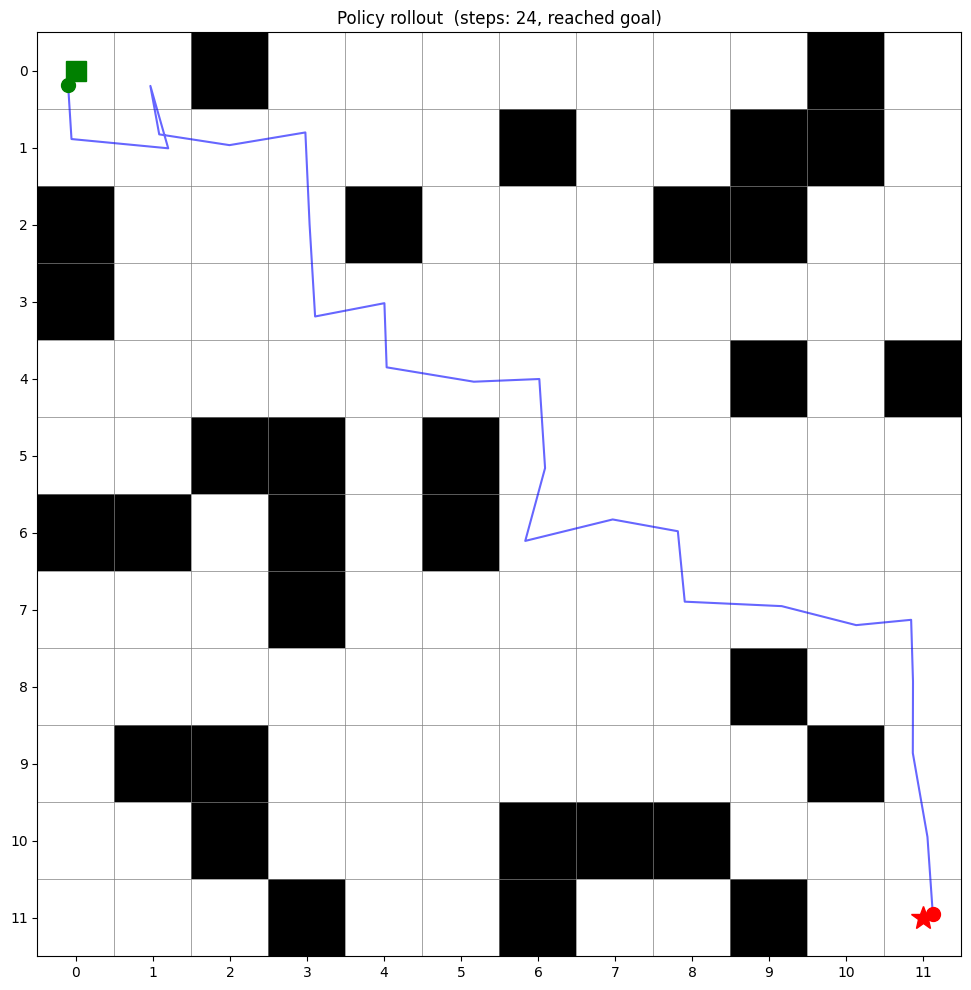

In [116]:
plot_maze_with_trajectory(env, theta, title="Policy rollout")

Sampling trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Steps distribution — success rate: 100.0%'}, xlabel='Steps', ylabel='Count'>

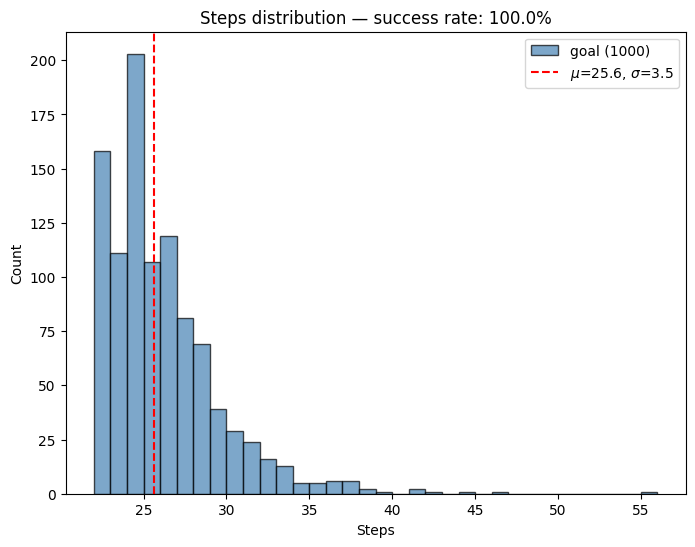

In [117]:
plot_steps_distribution(env, theta, n_trajectories=1000, figsize=(8, 6))

---
## Doing evaluation across multiple seeds for given Maze parameters:

In [162]:
def evaluate_policy(env, theta, n_eval=200):
    """Run n_eval episodes, return success rate and mean steps (goal-reaching only)."""
    success, goal_steps = 0, []

    for _ in range(n_eval):
        s = env.reset()
        done, t = False, 0
        while not done:
            a = sample_action(s, theta)
            s, _, done = env.step(a)
            t += 1
        if env._agent_pos == env.goal:
            success += 1
            goal_steps.append(t)

    rate = success / n_eval
    mean_steps = np.mean(goal_steps) if goal_steps else float('inf')
    return rate, mean_steps


def benchmark_reinforce(
    size,
    obstacle_pct=0.25,
    n_seeds=10,
    n_eval=200,
    n_iter=300,
    n_episodes=512,
    alpha=0.05,
    gamma=1.0,
    max_steps=300
):
    """
    For each seed: generate maze → train REINFORCE → evaluate.
    Returns dict with per-seed and aggregate results.
    """
    results = []

    for seed in tqdm(range(n_seeds), desc="Seeds"):
        env = generate_maze_env(size, obstacle_pct=obstacle_pct,
                                max_steps=max_steps, seed=seed)
        theta, mean_returns = train_reinforce(
            env, n_iter=n_iter, n_episodes=n_episodes,
            alpha=alpha, gamma=gamma
        )
        rate, mean_steps = evaluate_policy(env, theta, n_eval=n_eval)
        results.append({
            'seed': seed,
            'n_states': env.n_states,
            'success_rate': rate,
            'mean_steps': mean_steps,
            'final_return': mean_returns[-1],
        })

    rates = [r['success_rate'] for r in results]
    steps = [r['mean_steps'] for r in results if r['mean_steps'] != float('inf')]

    summary = {
        'size': size,
        'obstacle_pct': obstacle_pct,
        'n_seeds': n_seeds,
        'avg_success_rate': np.mean(rates),
        'std_success_rate': np.std(rates),
        'avg_steps': np.mean(steps) if steps else float('inf'),
        'std_steps': np.std(steps) if steps else float('inf'),
        'per_seed': results,
    }

    return summary

In [163]:
sizes = [2, 4, 6, 8, 10, 12, 14, 16]

In [ ]:
results = {
    "size": [],
    "obstacle_pct": [],
    "n_seeds": [],
    "avg_success_rate": [],
    "std_success_rate": [],
    "avg_steps": [],
    "std_steps": [],
}

for size in sizes:
    summary = benchmark_reinforce(size=size)
    results["size"].append(size)
    results["obstacle_pct"].append(summary["obstacle_pct"])
    results["n_seeds"].append(summary["n_seeds"])
    results["avg_success_rate"].append(summary["avg_success_rate"])
    results["std_success_rate"].append(summary["std_success_rate"])
    results["avg_steps"].append(summary["avg_steps"])
    results["std_steps"].append(summary["std_steps"])

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]

REINFORCE Iteration:   0%|          | 0/300 [00:00<?, ?it/s]